# Image Areafilter / De-Areafilter Demo

This notebook demonstrates how to area filter (box filter) original image and then attempt to reconstruct the original image.

## 1. Load Original Image

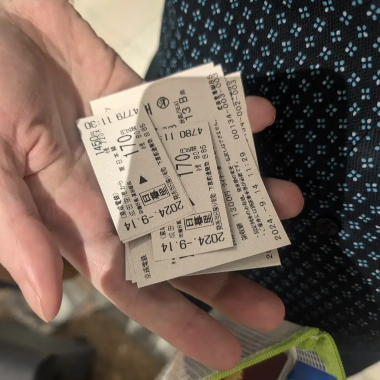

In [1]:
import PIL.Image as Image
import torchvision.transforms.functional as TF

original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = original.size()[-2:]

TF.to_pil_image(original[0])

## 2. Filter the Image

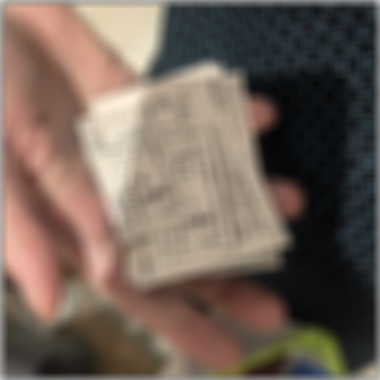

In [2]:
import torch
import torch.nn.functional as F

CHUNK_SIZE = 16

filtered = F.avg_pool2d(F.pad(original, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)), CHUNK_SIZE, 1)[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W]

TF.to_pil_image(filtered[0])

## 3. Restore the Original Image with Gradient-Decent

just gradient descent the `trained` (`filtered` as basis) to output `filtered` after a a `avg_pool2d` (~ `area` filter).

(could use deconvolution .. to calculate the output faster, since we know the PSF)

use device xpu
0.00% loss 0.015954038128256798
5.00% loss 0.005106283817440271
10.00% loss 0.0022918942850083113
15.00% loss 0.0010343819158151746
20.00% loss 0.00044510088628157973
25.00% loss 0.00021256487525533885
30.00% loss 0.00015647125837858766
35.00% loss 0.00012718935613520443
40.00% loss 0.00010954292520182207
45.00% loss 9.701543604023755e-05
50.00% loss 8.950986375566572e-05
55.00% loss 8.243421325460076e-05
60.00% loss 7.681675924686715e-05
65.00% loss 7.154871855163947e-05
70.00% loss 6.896862032590434e-05
75.00% loss 6.664236570941284e-05
80.00% loss 6.396829849109054e-05
85.00% loss 6.301857501966879e-05
90.00% loss 6.11599170952104e-05
95.00% loss 5.8739682572195306e-05


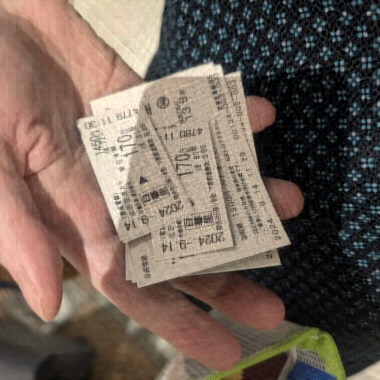

In [4]:
import torch.nn as nn
import torch.optim as optim

device = 'cpu'
if torch.xpu.is_available():
    device = 'xpu'
elif torch.cuda.is_available():
    device = 'cuda'
print('use device', device)

filtered = filtered.to(device)
trained = nn.Parameter(filtered.clone(), requires_grad=True)

optimizer = optim.Adam([trained])
ROUNDS = 2000
for i in range(ROUNDS):
    #frame_trained.data.add_(torch.randn_like(frame_trained).mul_(1/1024))
    optimizer.zero_grad()
    loss = F.l1_loss(
        F.avg_pool2d(F.pad(trained, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)), CHUNK_SIZE, 1)[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W],
        filtered
    )
    loss.backward()
    optimizer.step()
    trained.data.clamp_(0, 1)
    if (i % 100) == 0:
        print(f'{i / ROUNDS * 100:03.2f}%', 'loss', float(loss))

TF.to_pil_image(trained[0])